# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm-research/ttm-research-r2)

### The get_model() utility
TTM Model card offers a suite of models with varying `context_length` and `prediction_length` combinations.
In this notebook, we will utilize the TSFM `get_model()` utility that automatically selects the right model based on the given input `context_length` and `prediction_length` (and some other optional arguments) abstracting away the internal complexity. See the usage examples below in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions. For more details see the [docstring](https://github.com/ibm-granite/granite-tsfm/blob/main/tsfm_public/toolkit/get_model.py) of the function definition.

## Install `tsfm` 
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [ ]:
# Install the tsfm library
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.18) to /private/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/pip-install-nbfjvfee/tsfm-public_8e2aa50a6eba4669adf63019e1085650
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /private/var/folders/mz/8xvqd9y134510qh2hy9fj_7c0000gn/T/pip-install-nbfjvfee/tsfm-public_8e2aa50a6eba4669adf63019e1085650
  Running command git checkout -q 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 4db1cfd157767c8de39bedb5c1f90a8d7d6e5850
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Imports

In [2]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

/Users/lauraboggia/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/lauraboggia/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <E18DFE52-852D-394A-A057-B368245EF139> /Users/lauraboggia/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <25C510F7-7AEE-3D64-80ED-95874DC6BECD> /Users/lauraboggia/miniforge3/envs/torch/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/lauraboggia/miniforge3/envs/torch/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The

In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [4]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm-research/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 512

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 10

TARGET_DATASET = "GECCO"
dataset_path = "/Users/lauraboggia/Library/CloudStorage/Box-Box/Laura_PhD/VSCode_projects/iTransformerAD/data/GECCO/1_gecco2018_water_quality.csv"
# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [5]:
# Dataset
TARGET_DATASET = "GECCO"
dataset_path = "/Users/lauraboggia/Library/CloudStorage/Box-Box/Laura_PhD/VSCode_projects/iTransformerAD/data/GECCO/1_gecco2018_water_quality.csv"
timestamp_column = "Time"
id_columns = []  # mention the ids that uniquely identify a time-series.

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

labels = data['EVENT']
data = data.drop(columns=['EVENT'])
length = len(data)
split1 = int(length*0.2)
split2 = int(length*0.3)
split3 = int(length*0.4)

target_columns = ["Tp","Cl","pH","Redox","Leit","Trueb","Cl_2","Fm","Fm_2"]
split_config = {
    "train": [0, split1],
    "valid": [split1, split2],
    "test": [
        split2,
        split3,
    ],
}
print(split_config)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

{'train': [0, 27913], 'valid': [27913, 41869], 'test': [41869, 55826]}


## Zero-shot evaluation method

In [6]:
import torch
import numpy as np

In [24]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    split1 = int(length*0.5)
    split2 = int(length*0.8)
    split3 = int(length)
    split_config = {
        "train": [0, 0.1],
        "valid": [0.1, 0.2],
        "test": [
            0.5,
            split3,
        ],
    }
    _, _, dset_test = get_datasets(tsp, data, split_config)
    print(dset_test[0].keys())

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print(zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # # plot
    # plot_predictions(
    #     model=zeroshot_trainer.model,
    #     dset=dset_test,
    #     plot_dir=os.path.join(OUT_DIR, dataset_name),
    #     plot_prefix="test_zeroshot",
    #     indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
    #     channel=0,
    # )
    return predictions_np, dset_test

In [ ]:
def zeroshot_valid(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    split1 = int(length*0)
    split2 = int(length*0.4)
    split3 = int(length*0.5) # real test data starts from 0.8, so we can use 0.6 as validation
    split_config = {
        "train": [0, 1],
        "valid": [1, 2],
        "test": [
            split2,
            split3,
        ],
    }
    _, _, dset_valid = get_datasets(tsp, data, split_config)
    print(dset_valid[0].keys())
    print(dset_valid.__len__())

    # Load model
    zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_valid)
    print(zeroshot_output)

    # get predictions
    predictions_dictT = zeroshot_trainer.predict(dset_valid)
    predictions_npT = predictions_dictT.predictions[0][:,-1,:]
    print(predictions_npT.shape)

    true_train = torch.Tensor()
    for i in range(len(dset_valid)):
        new = dset_valid[i]['future_values'][0].unsqueeze(0)
        true_train = torch.cat((true_train, new), dim=0)
    true_train = true_train.numpy()    
    loss_train = (predictions_npT - true_train) ** 2

    # # plot
    # plot_predictions(
    #     model=zeroshot_trainer.model,
    #     dset=dset_valid,
    #     plot_dir=os.path.join(OUT_DIR, dataset_name),
    #     plot_prefix="test_zeroshot",
    #     indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
    #     channel=0,
    # )
    return loss_train
    


# Zeroshot

In [26]:
pred, testset,  = zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

INFO:p-29369:t-8749582400:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-29369:t-8749582400:get_model.py:get_model:Selected TTM `prediction_length` = 96


dict_keys(['past_values', 'future_values', 'past_observed_mask', 'future_observed_mask', 'timestamp', 'id'])


INFO:p-29369:t-8749582400:get_model.py:get_model:Model loaded successfully!
INFO:p-29369:t-8749582400:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 1.8583683967590332, 'eval_model_preparation_time': 0.0041, 'eval_runtime': 165.6233, 'eval_samples_per_second': 421.281, 'eval_steps_per_second': 6.587}


RuntimeError: MPS backend out of memory (MPS allocated: 17.32 GB, other allocations: 90.59 MB, max allowed: 18.13 GB). Tried to allocate 753.75 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

In [10]:
lossT = zeroshot_valid(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

INFO:p-29369:t-8749582400:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-29369:t-8749582400:get_model.py:get_model:Selected TTM `prediction_length` = 96


dict_keys(['past_values', 'future_values', 'past_observed_mask', 'future_observed_mask', 'timestamp', 'id'])
13947


INFO:p-29369:t-8749582400:get_model.py:get_model:Model loaded successfully!
INFO:p-29369:t-8749582400:get_model.py:get_model:[TTM] context_len = 512, forecast_len = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.05227406322956085, 'eval_model_preparation_time': 0.0035, 'eval_runtime': 47.5691, 'eval_samples_per_second': 293.195, 'eval_steps_per_second': 4.583}
(13947, 9)


In [11]:
pred1 = pred[:, -1, :]
feats = pred1.shape[1]

In [12]:
labels = np.array(labels)
labels = labels[-pred1.shape[0]:, np.newaxis]
labels = np.repeat(labels, feats, axis=1)
print(labels.shape)

(27905, 9)


In [13]:
true = torch.Tensor()
for i in range(len(testset)):
    new = testset[i]['future_values'][0]
    new = new.unsqueeze(0)
    true = torch.cat((true, new), dim=0)
true = true.numpy()
print(true.shape)
loss = (pred1 - true) ** 2
print(loss.mean(), loss.shape)

(27905, 9)
0.64110225 (27905, 9)


In [14]:
%matplotlib inline

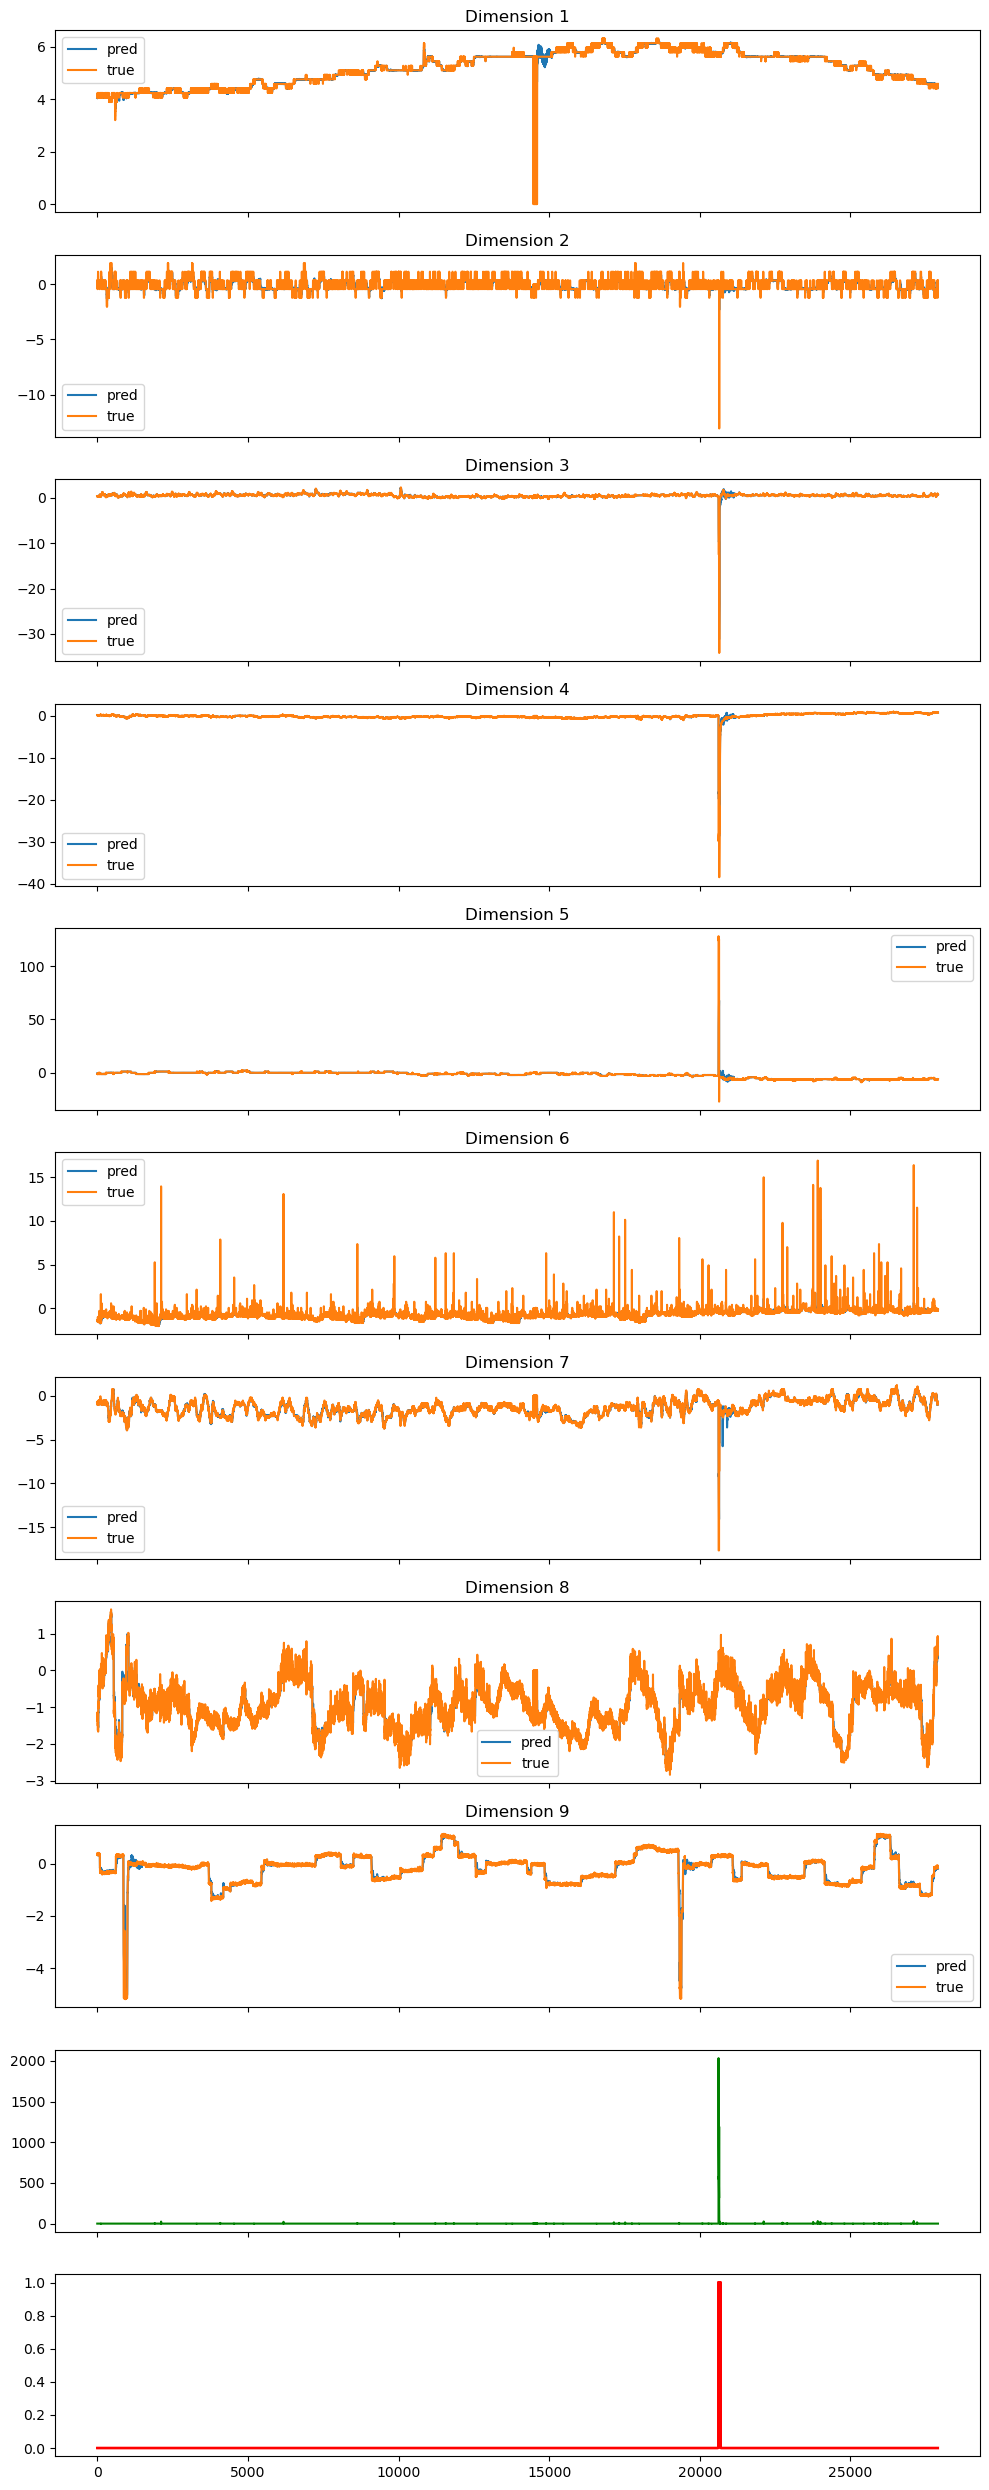

In [15]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(pred1.shape[1]+2, 1, figsize=(10, 25), sharex=True)

for i in range(pred1.shape[1]):
    axs[i].plot(pred1[:, i], label='pred')
    axs[i].plot(true[:, i], label='true')
    axs[i].set_title(f'Dimension {i+1}')
    axs[i].legend()

axs[-2].plot(loss.mean(axis=1), 'g', label='anomaly score')
axs[-1].plot(labels, 'r', label='anomaly labels')

plt.tight_layout()
plt.show()

In [16]:
import sys
module_path = '/Users/lauraboggia/Library/CloudStorage/Box-Box/Laura_PhD/VSCode_projects/iTransformerAD'
if module_path not in sys.path:
    sys.path.append(module_path)

In [17]:
from main import local_pot, local_anomaly_labels
from src.pot import pot_eval
from src.plotting import compare_labels, plot_metrics

ModuleNotFoundError: No module named 'reformer_pytorch'

In [ ]:
q = 1e-5
plot_path = '/Users/lauraboggia/Library/CloudStorage/Box-Box/Laura_PhD/VSCode_projects/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/GECCO' 

In [ ]:
preds, df_res_local = local_pot(loss, lossT, labels, q, None)
true_labels = (np.sum(labels, axis=1) >= 1) + 0
# local anomaly labels
labelspred, result_local1 = local_anomaly_labels(preds, true_labels, q, None, nb_adim=1)
majority = math.ceil(labels.shape[1] / 2)	# do majority voting over dimensions for local results instead of inclusive OR
labelspred_maj, result_local2 = local_anomaly_labels(preds, true_labels, q, None, nb_adim=majority)
labelspred_all = []
results_all = pd.DataFrame()
if feats > 20:
    nb_adim = np.unique(np.concatenate((np.arange(1, 11), np.arange(20, feats, 10), [feats])))
else:
    nb_adim = np.arange(1, feats+1)
for i in nb_adim:
    lpred, res = local_anomaly_labels(preds, true_labels, q, None, nb_adim=i)
    labelspred_all.append(lpred)
    results_all = pd.concat([results_all, pd.DataFrame.from_dict(res, orient='index').T], ignore_index=True)

results_all.index = nb_adim
results_all.to_csv(f'{plot_path}/res_local_all.csv')

# global anomaly labels
lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
true_labels = (np.sum(labels, axis=1) >= 1) + 0
result_global, pred2 = pot_eval(lossTfinal, lossFinal, true_labels, plot_path, f'all_dim', q=q)
labelspred_glob = (pred2 >= 1) + 0

result_global.update({'train_loss': lossT.mean(), 'test_loss': loss.mean()})
print('\nglobal results') 
print(result_global)

plot_metrics(plot_path, ['local (incl. OR)', 'local (maj. voting)', 'global'], 
            y_pred=[labelspred, labelspred_maj, labelspred_glob], y_true=true_labels)

# compare local & global anomaly labels
compare_labels(plot_path, pred_labels=[labelspred, labelspred_maj, labelspred_glob], true_labels=true_labels, 
            plot_labels=['Local anomaly\n(inclusive OR)', 'Local anomaly\n(majority voting)', 'Global anomaly'], name='_all')

# saving results
df_res_global = pd.DataFrame.from_dict(result_global, orient='index').T
df_res_global.index = ['global']
result_local1 = pd.DataFrame.from_dict(result_local1, orient='index').T
result_local2 = pd.DataFrame.from_dict(result_local2, orient='index').T
result_local1.index = ['local_all']
result_local2.index = ['local_all_maj']
df_res_local = pd.concat([df_res_local, result_local1, result_local2])
df_res = pd.concat([df_res_local, df_res_global]) 
df_labels = pd.DataFrame( {'local': labelspred, 'local_maj': labelspred_maj, 'global': labelspred_glob} )

df_res.to_csv(f'{plot_path}/res.csv')	
df_labels.to_csv(f'{plot_path}/pred_labels.csv', index=False)


 ## Few-shot finetune and evaluation method

In [ ]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
        channel=0,
    )

### Few-shot 5%

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
)

# Fewshot with quantile loss (We can use pinball loss to generate different quantiles as required)

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=0.001,
    loss="pinball",
    quantile=0.5,
)

## Example: TTM for other forecast horizon lengths and context lengths

The minimum / maximum supported context length for the Granite-TTM-R2 models are 52 and 1536 respectively. Whereas the maximum supported prediction length for Granite-TTM-R2 is 720. (For other models, see the respective model cards) 

However, we can ask for a different context length or forecast length, and the `get_model()` utility will choose the closest possible TTM from the model suite. We have to make sure that the required context and prediction lengths are passed to the `TimeSeriesPreprocessor()` so that the data batches are generated correctly. In this notebook, this is handled in the `zeroshot_eval()` and `fewshot_finetune_eval()` functions.

### Zero-shot

In [ ]:
zeroshot_eval(dataset_name=TARGET_DATASET, context_length=1024, forecast_length=48, batch_size=64)

### Few-shot 5%

In [ ]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=1536,
    forecast_length=48,
    batch_size=64,
    fewshot_percent=5,
    learning_rate=None,
)